<h1>Random Forest</h1>

En este cuaderno, se implementa una estrategia de imputación supervisada utilizando Random Forest para manejar los valores faltantes en un conjunto de datos. Random Forest es un modelo basado en árboles de decisión, que combina múltiples árboles para generar predicciones más robustas y precisas. Esta capacidad de modelar relaciones no lineales lo hace especialmente útil para la imputación de valores faltantes en datos complejos.

Debido a la naturaleza computacionalmente intensiva de los modelos basados en árboles, se utiliza un subconjunto reducido de datos para entrenar el modelo y evaluar su rendimiento en la imputación.

Los principales objetivos de este cuaderno son:

- Imputar valores faltantes en un conjunto de datos mediante el uso de Random Forest.
- Evaluar el impacto de los diferentes niveles de incompletitud en el rendimiento del modelo.
- Guardar los modelos entrenados y los datasets imputados para su posterior análisis y uso.

Descripción del enfoque :
- Entrenamiento con datos completos: El modelo de Random Forest se entrena con un subconjunto de datos sin valores faltantes para aprender las relaciones entre las variables.
- Generación de conjuntos de test con incompletitud: A partir del conjunto de test, se crean subconjuntos con distintos porcentajes de datos faltantes (10%, 20%, 30%, 40%).
- Imputación de datos faltantes: El modelo entrenado se utiliza para predecir los valores faltantes en cada subconjunto de test, evaluando su capacidad de reconstrucción según el nivel de pérdida de datos.
- Evaluación del rendimiento: Se analizan las métricas obtenidas en cada nivel de incompletitud para observar cómo afecta la cantidad de datos faltantes a la precisión del modelo.
- Almacenamiento de resultados: Los modelos y datasets imputados se guardan para análisis y comparaciones posteriores entre diferentes enfoques de imputación.

## Importación de librerias



In [2]:

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt


# Dataset

## Loading data

Se utilizan los subconjuntos de datos generados en preprocesamiento, en formato parquet para optimizar la lectura

In [3]:
df_train = pd.read_parquet('../data/processed/df_train_reduced.parquet')
df_test= pd.read_parquet('../data/processed/df_test_reduced.parquet')
df_test_missing_10 = pd.read_parquet('../data/processed/df_test_reduced_missing_10.parquet')
df_test_missing_20 = pd.read_parquet('../data/processed/df_test_reduced_missing_20.parquet')
df_test_missing_30 = pd.read_parquet('../data/processed/df_test_reduced_missing_30.parquet')
df_test_missing_40 = pd.read_parquet('../data/processed/df_test_reduced_missing_40.parquet')

In [4]:
df_test_missing_10.head(10)

,10335183_chrXV_303214_G_T,10341838_chrXV_309869_T_C,10341923_chrXV_309954_G_A,10342190_chrXV_310221_T_C,10342543_chrXV_310574_A_G,10344120_chrXV_312151_C_T,10346156_chrXV_314187_C_G,10349298_chrXV_317329_C_T,3141305_chrV_249350_C_T,10383039_chrXV_351070_C_T,...,10640336_chrXV_608367_C_T,1428699_chrIV_68677_T_C,1428933_chrIV_68911_A_C,6970183_chrXI_391971_C_T,6970060_chrXI_391848_C_T,6969970_chrXI_391758_T_A,3698349_chrVI_229520_A_G,6969924_chrXI_391712_C_T,5535875_chrIX_143302_C_T,7948843_chrXII_703815_C_T
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,2.0,1.0,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0
2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,2.0,1.0
3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,...,1.0,2.0,2.0,2.0,NaN,2.0,NaN,2.0,2.0,2.0
4,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,...,1.0,1.0,1.0,2.0,2.0,NaN,2.0,2.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,2.0,NaN,2.0,1.0,2.0,2.0,2.0
6,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,...,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0
7,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0
9,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,2.0,1.0,...,1.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,1.0


In [5]:
df_train.head(10)

,10335183_chrXV_303214_G_T,10341838_chrXV_309869_T_C,10341923_chrXV_309954_G_A,10342190_chrXV_310221_T_C,10342543_chrXV_310574_A_G,10344120_chrXV_312151_C_T,10346156_chrXV_314187_C_G,10349298_chrXV_317329_C_T,3141305_chrV_249350_C_T,10383039_chrXV_351070_C_T,...,10640336_chrXV_608367_C_T,1428699_chrIV_68677_T_C,1428933_chrIV_68911_A_C,6970183_chrXI_391971_C_T,6970060_chrXI_391848_C_T,6969970_chrXI_391758_T_A,3698349_chrVI_229520_A_G,6969924_chrXI_391712_C_T,5535875_chrIX_143302_C_T,7948843_chrXII_703815_C_T
0,1,1,1,1,1,1,1,1,2,2,...,2,2,2,1,1,1,2,1,1,1
1,2,2,2,2,2,2,2,2,1,1,...,1,2,2,1,1,1,1,1,1,2
2,2,2,2,2,2,2,2,1,2,1,...,1,1,1,2,2,2,1,2,2,1
3,1,1,1,1,1,1,1,1,1,2,...,2,1,1,2,2,2,2,2,2,2
4,2,2,2,2,2,2,2,2,1,2,...,1,2,2,1,1,1,2,1,2,1
5,2,2,2,2,2,2,2,2,2,2,...,2,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,1,2,1,2
7,2,2,2,2,2,2,2,2,1,1,...,1,2,2,2,2,2,2,2,1,1
8,1,1,1,1,1,1,1,1,2,1,...,1,1,1,1,1,1,1,1,2,1
9,1,1,1,1,1,1,1,1,2,2,...,2,2,2,1,1,1,2,1,1,2


### Mostramos el numero de clases de entrenamieno y verificamos que están balanceadas

In [6]:
# Contar los valores de 0 y 1 en todo el DataFrame
total_counts = df_train.apply(pd.Series.value_counts).sum(axis=1)
print("Conteo total de clases en todo el DataFrame:")
print(total_counts)

Conteo total de clases en todo el DataFrame:
1    1756511
2    1756489
dtype: int64


# RANDOM FOREST

Definimos la función que se encargarña de entrenar el modelo

In [7]:
from sklearn.ensemble import RandomForestClassifier
import time
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestClassifier

def train_model(df_train):
    X_train = df_train
    y_train = X_train.values  # Se usan los valores de X como etiquetas

    # Entrenar un Random Forest Classifier
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)  # Entrenamos el modelo usando los valores no faltantes
    return rf_model


### Test 

In [8]:
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

def predict_missing_values_for_row(row, model, known_features, missing_features):
    # Asegurarse de que la fila tenga los nombres de las columnas correctos
    X_known = row[known_features].values.reshape(1, -1)

    # Crear un dataframe vacío con las columnas del modelo y rellenar con ceros (o cualquier valor temporal)
    X_full = pd.DataFrame(np.zeros((1, model.n_features_in_)), columns=model.feature_names_in_)
    
    # Rellenar las características conocidas en sus correspondientes columnas
    X_full.loc[:, known_features] = X_known

    # Hacer la predicción usando el modelo entrenado
    pred = model.predict(X_full)[0]

    return pred, missing_features

# Imputar valores faltantes y calcular métricas
def impute_and_evaluate(df_test_missing, df_test_original, model):
    df_test_imputed = df_test_missing.copy()  # Mantener el dataframe con su estructura

    all_y_true = []
    all_y_pred = []

    # Iterar sobre cada fila del dataset
    for index, row in df_test_missing.iterrows():
        if row.isna().any():  # Solo imputar filas con valores faltantes
            known_features = row.dropna().index  # Características conocidas (no NaN)
            missing_features = row.index[row.isna()]  # Características con NaN

            # Si hay suficientes características conocidas, predecir los NaN
            if len(known_features) > 0:
                pred, missing_features = predict_missing_values_for_row(
                    row, model, known_features, missing_features
                )

                # Imputar los valores predichos en el dataset
                df_test_imputed.loc[index, missing_features] = pred[:len(missing_features)]

                # Guardar los valores verdaderos y predichos para evaluación
                y_true = df_test_original.loc[index, missing_features]
                all_y_true.extend(y_true)
                all_y_pred.extend(pred[:len(missing_features)])

    # Calcular las métricas de evaluación
    accuracy_general = accuracy_score(all_y_true, all_y_pred)
    f1_macro = f1_score(all_y_true, all_y_pred, average='macro')
    precision_macro = precision_score(all_y_true, all_y_pred, average='macro')
    recall_macro = recall_score(all_y_true, all_y_pred, average='macro')

    return df_test_imputed, accuracy_general, f1_macro, precision_macro, recall_macro

# Función para procesar diferentes niveles de missingness
def process_multiple_missingness_levels(df_train, df_test, missingness_levels, rf_model):
    results = {
        "accuracy": [],
        "f1": [],
        "precision": [],
        "recall": []
    }

    for level in missingness_levels:
        df_test_missing = globals()[f'df_test_missing_{level}']  # Conjunto de test con missingness
        
        # Imputar los valores faltantes
        df_test_imputed, accuracy, f1, precision, recall = impute_and_evaluate(
            df_test_missing, df_test, rf_model
        )

        # Guardar las métricas
        results["accuracy"].append(accuracy)
        results["f1"].append(f1)
        results["precision"].append(precision)
        results["recall"].append(recall)
        
        # Guardar el conjunto imputado como una variable global
        globals()[f'df_test_missing_{level}_imputed'] = df_test_imputed

    return results

# Función para graficar los resultados
def plot_multiple_metrics(missingness_levels, metrics_dict):
    plt.figure(figsize=(10, 6))
    
    for metric_name, metric_values in metrics_dict.items():
        plt.plot(missingness_levels, metric_values, marker='o', label=f'{metric_name}')
    
    plt.xlabel('Porcentaje de valores faltantes')
    plt.ylabel('Métrica')
    plt.title('Comparación de métricas vs Porcentaje de valores faltantes')
    plt.grid(True)
    plt.legend()
    plt.show()


def detailed_metrics_report(missingness_levels, metrics_dict):
    # Reportar métricas numéricas
    print("==== Reporte Detallado de Métricas ====\n")
    for metric_name, metric_values in metrics_dict.items():
        print(f"Métricas para {metric_name}:")
        for i, level in enumerate(missingness_levels):
            print(f"- Porcentaje de valores faltantes {level}%: {metric_values[i]:.4f}")
        print("\n")
    


In [9]:
rf_model = train_model(df_train)  # Aquí entrenamos el modelo una sola vez


In [10]:
# Llamar al proceso con el modelo ya entrenado
missingness_levels = [10, 20, 30, 40]
metrics_results = process_multiple_missingness_levels(df_train, df_test, missingness_levels, rf_model)

In [11]:
detailed_metrics_report(missingness_levels, metrics_results)

==== Reporte Detallado de Métricas ====

Métricas para accuracy:
- Porcentaje de valores faltantes 10%: 0.5364
- Porcentaje de valores faltantes 20%: 0.5420
- Porcentaje de valores faltantes 30%: 0.5298
- Porcentaje de valores faltantes 40%: 0.5156


Métricas para f1:
- Porcentaje de valores faltantes 10%: 0.5364
- Porcentaje de valores faltantes 20%: 0.5415
- Porcentaje de valores faltantes 30%: 0.5277
- Porcentaje de valores faltantes 40%: 0.5095


Métricas para precision:
- Porcentaje de valores faltantes 10%: 0.5364
- Porcentaje de valores faltantes 20%: 0.5424
- Porcentaje de valores faltantes 30%: 0.5304
- Porcentaje de valores faltantes 40%: 0.5172


Métricas para recall:
- Porcentaje de valores faltantes 10%: 0.5364
- Porcentaje de valores faltantes 20%: 0.5422
- Porcentaje de valores faltantes 30%: 0.5299
- Porcentaje de valores faltantes 40%: 0.5163




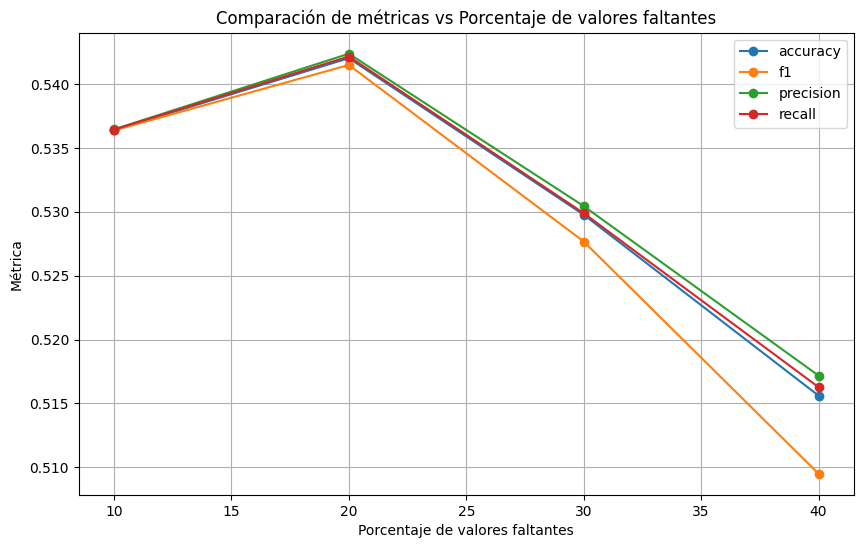

In [12]:
# Graficar resultados
plot_multiple_metrics(missingness_levels, metrics_results)

### Guardar datasets imputados a partir de los distintos datasets con diferentes porcentajes de missingness y modelo generado

In [13]:
import os
import h5py
import pickle
import numpy as np

def save_model(rf_model, model_path):
    os.makedirs(os.path.dirname(model_path), exist_ok=True)  # Crear directorios si no existen
    
    # Serializamos el modelo con pickle en un buffer de bytes
    model_bytes = pickle.dumps(rf_model)
    
    # Convertir el buffer a un array NumPy para que HDF5 lo maneje correctamente
    model_array = np.frombuffer(model_bytes, dtype='uint8')
    
    # Guardar el modelo en un archivo HDF5 con compresión GZIP
    with h5py.File(model_path, 'w') as f:
        # Dividimos el array en chunks y aplicamos compresión
        f.create_dataset('random_forest_model', data=model_array, compression="gzip", compression_opts=9)
    
    print(f"Modelo guardado y comprimido en {model_path}")


# Función para guardar los datasets imputados
def save_imputed_datasets(df_imputed, level, output_dir):
    os.makedirs(output_dir, exist_ok=True)  # Crear directorios si no existen
    file_path = os.path.join(output_dir, f'df_test_missing_{level}_imputed.parquet')
    df_imputed.to_csv(file_path, index=False)
    print(f"Dataset imputado guardado en {file_path}")


In [14]:


# Guardar el modelo
model_output_path = "../models/random_forest/random_forest_general_model.h5"
save_model(rf_model, model_output_path)

# Guardar los datasets imputados
for level in missingness_levels:
    df_test_imputed = globals()[f'df_test_missing_{level}_imputed']
    data_output_dir = "../data/generated/random_forest"
    save_imputed_datasets(df_test_imputed, level, data_output_dir)


Modelo guardado y comprimido en ../models/random_forest/random_forest_general_model.h5
Dataset imputado guardado en ../data/generated/random_forest/df_test_missing_10_imputed.parquet
Dataset imputado guardado en ../data/generated/random_forest/df_test_missing_20_imputed.parquet
Dataset imputado guardado en ../data/generated/random_forest/df_test_missing_30_imputed.parquet
Dataset imputado guardado en ../data/generated/random_forest/df_test_missing_40_imputed.parquet


Así se cargaría el modelo de ser necesario desde HDF5:
with h5py.File('models/random_forest/random_forest_general_model.h5', 'r') as f:
    model_bytes = f['random_forest_model'][()]
    f_model_loaded = joblib.loads(model_bytes)
    